**Rita Kurban**

**Professor Sterne**

**CS110**

 

A Bloom filter is a space-efficient probabilistic data structure, invented by Burton Howard Bloom in 1970. It is used to test whether an element is a member of a set. 

The base data structure of a Bloom filter is a Bit Vector. Similar to hash tables, basic Bloom Filters support two operations:  add and search.

To add an element to the Bloom filter, we hash it a few times using different functions and set the bits in the bit vector at the index of those hashes to 1. As a result, we don't store the item itself, only a few bits, which makes the structure very space-efficient. To ensure quick addition, we have to use fast hash functions. They don't have to be cryptographic because we only care about them being uniformly distributed and independent. 

It is important to note that deletions from a simple filter are not possible. If we want to remove a single element by clearing the bits at indices calculated by the hash functions, we might as well delete other items. Some extensions, such as counting filters, allow removal. However, we won't discuss them in this introduction.  

By design, Bloom Filters allow for hash collisions which makes them very compact but also results in false positives. If, for example, we are searching for an element which was not added to the data structure, there is a small chance that some other items set the bits at these exact indexes to 1. The false positive rate decreases as the array's size and the number of hash functions increase. Since Bloom Filters make a tradeoff between space-efficiency and accuracy, they are called a probabilistic data structure. Bloom Filters cannot produce a list of inserted items. It is only possible to check whether every single element is in the array. Despite these disadvantages, they are extremely good at searching, which they do in constant time, just by calculating hashes and checking whether at least one of them is 0. If so, we can be sure that the element was never added to the array, as Bloom Filters never result in false negatives. 

If false positives is not a big deal and the memory is restricted, Bloom filters are a perfect tool for looking up the elements. For this reason, they have a variety of real-life applications:

Multiple websites use bloom filters to quickly check the availability of a username or filter out weak passwords.

Companies like Medium or Quora use bloom filters to recommend posts which haven't been seen by the user.

Multiple web browsers, including the Google Chrome, use a Bloom filter to avoid redirecting users to malicious websites.

Bloom filters are also widely used in bioinformatics to search for specific DNA sequences through the entire genome.

Bloom filters are also used in the Bitcoin peer-to-peer communication infrastructure to speed up wallet synchronization.

In [98]:
import mmh3
import math

class BloomFilter:
# The parameters which the user should give is the probability
# of false positives and the number of elements
# we are planning to add to the filter
    def __init__(self, p, n_elements):
        self.p = p
# The optimal size as well as the number of hash functions
# are calculated using the formulas described below
        self.size = int((-n_elements * math.log(self.p)) / ((math.log(2)) ** 2.))    
        self.n_hash = int((self.size / n_elements) * math.log(2.))
# This part initiates an array filled with 0s
        self.array = [0]*self.size
        self.n_elements = n_elements

# This function first hashes the item n_hast times 
# and then sets the respective bits to 1.
def add(self, item):
    for seed in xrange(self.n_hash):
        index = mmh3.hash(item,seed) % self.size
        self.array[index] = 1
    
# The function calculates hashes and then checks if all
# the indexes equal 1, if they do, the search is successful.
def search(self,item):
    indexes = []
    for seed in xrange(self.n_hash):
        index = mmh3.hash(item,seed) % self.size
        if self.array[index] == 0:
            return False
    return True
        

In the implementation above, I use the package mmh3 which is a set of fast and robust hash functions called MurmurHash. MurmurHash was created by Austin Appleby in 2008 and is currently available on Github (https://github.com/aappleby/smhasher/blob/master/src/MurmurHash3.cpp). The name comes from two basic operations, multiply (MU) and rotate (R), used in its inner loop.
Murmur hashing functions are not specifically designed to be difficult to reverse by an adversary but suitable for our non-cryptographic purposes. They are also one of the highly recommended set of functions to use in Bloom Filters as they are very quick and help to maximize the quality of the distribution as well as minimize the number of collisions. The code above uses the same hash function with different seeds. The seed parameter is a means to randomize the hash function so that different seeds give different hashes for the same input which is exactly what we need for Bloom Filters.



a-b) In Bloom Filters, the memory size (m) is a function of false positive rates (p) and the number of items inserted (n). In a data structure of a fixed size, it is possible to insert a set with an arbitrarily large number of elements. Adding an element never fails due to the data structure "filling up." However, the false positive rate increases steadily as elements are added until all bits in the filter are set to 1. At this point, any search will be successful and the false positive rate equals 1. This problem can be solved by increasing the memory size or defining it regarding p and n. My implementation of the Bloom Filter always calculates the optimal size using the error rate and the number of insertions provided by the user which makes the situation described above impossible. The bigger the false positive rate, the smaller the size of the array must be; the bigger the number of elements inserted, the bigger the memory size must be: $$m = -\frac{n\ln (p)}{(\ln 2)^2}$$

c-d) Access time also depends on the false positive rate and the number of items stored. In Bloom filters, the running time mostly depends on how quick the hash functions are. It takes constant time to check the bits or set them to ones while the hash functions themselves are slower because they have to perform multiple operations. That's why the more hash functions we have, the longer the function runs. As my implementation of the Bloom Filter always tries to set an optimal number of hash functions (k), the running time is defined by the following formula: $$ k = \frac{m}{n} \ln 2$$ If the memory size is small we can use fewer hash functions. The memory size depends on the false positive rate set by the user as discussed above. If the error rate is very high, the memory size gets smaller, and that's why the number of functions used decreases to 0. After a certain error rate (40% in my case, as discussed below), the filter starts to use only one function which results in extremely high error rate (it converges to 1). That's why, the smaller the error rate is, the bigger the number of functions is. Despite the fact that n is in the denominator, by increasing it, we also increase m, which means the number of hash functions also increases.



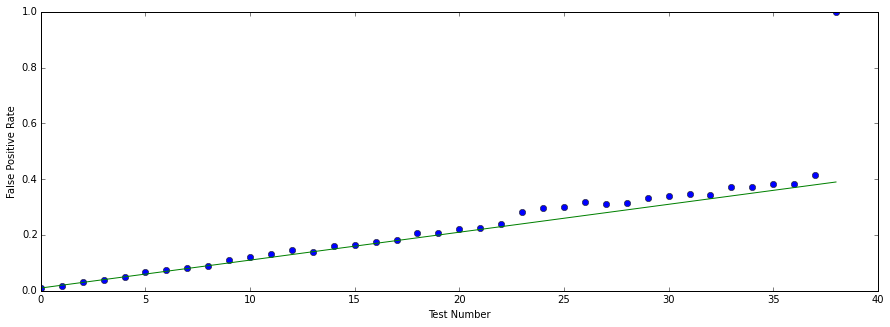

In [104]:
import random
import string
import matplotlib.pyplot as plt
%matplotlib inline

# I create two lists of words, one of them is used to fill in
# the Bloom Filter, the other one consists of words which
# have different lengths and is used to test for false positives.
words = []
tests = []
for i in range(1000):
    word = ''.join(random.choice(string.ascii_uppercase + string.digits) 
                   for i in range(5))
    words.append(word)
for i in range(10000):
    test = ''.join(random.choice(string.ascii_uppercase + string.digits)
                   for i in range(6))
    tests.append(test)
    

error_rate =[]
count = 0
emp = []

# I set different false positive rates (from 1 to 40%) to
# compare theoretical rates with what I get in practice
for p in range(1,40,1):
    p = p/100.
    error_rate.append(p)
    filt= BloomFilter(p,1000)
    for word in words:
        add(filt,word)
    count = 0
# There is no way for a search to be successful, as we are
# checking for words of different length, that's why each
# successful search is a false positive
    for test in tests:
        if search(filt, test) == True:
            count += 1
    emp.append(count/10000.)

# The following diagram shows that the Bloom Filter gives
# reasonably accurate results for the values of p < 40%
# If p gets bigger, the number of hash functions used decreases
# which leads to inaccurate search results. 
# In practice, we never use such large error rates,
# that's why it's not an issue.
plt.figure(figsize=(15,5))
plt.plot(emp, marker='o', linestyle = "None")
plt.plot(error_rate)
plt.ylabel('False Positive Rate')
plt.xlabel('Test Number')
plt.show()

HC dataviz - I plotted the theoretical error rates and the ones that I got in practice. The figure demonstrates how the actual error rate matches with the theoretical for p < 40%. In practice, people don't want an error rate that exceeds 5%, or in exceptional cases, 10%. This means that my implementation of the Blue Filter is applicable for the majority of practical problems.

HC sampling - I generated two lists with words of different lengths to test how real false positive rates match the ones I got in practice. To create the lists, I used the "random" package to sample strings from a (pseudo-)random distribution and used a length of 5 and 6 respectively to decrease the probability of generating identical words. 

HC variables - To implement the Bloom Filter, I identified relevant features of this class using the characteristics I listed in the introduction. After that, I determined the relationship between the error rate, the memory size, the number of elements inserted, and the running time of the program and calculated their optimal values with the help of formulas.

Sources:
    
1. Appleby, A. (2014). MurmurHash3 http://code. google. com/p/smhasher/wiki.
2. Bloom, B. H. (1970). Space/time trade-offs in hash coding with allowable errors. Communications of the ACM, 13(7), 422-426.
3. Bloom filter. (2017, November 2). In Wikipedia, The Free Encyclopedia. Retrieved 12:58, November 2, 2017, from https://en.wikipedia.org/w/index.php?title=Bloom_filter&oldid=808343654
